## Models, simulation, and degrees of belief

One view of knowledge is that the mind maintains working models of parts of the world. ‘Model’ in the sense that it captures some of the structure in the world, but not all (and what it captures need not be exactly what is in the world—just what is useful). ‘Working’ in the sense that it can be used to simulate this part of the world, imagining what will follow from different initial conditions. As an example take the Plinko machine: a box with uniformly spaced pegs, with bins at the bottom. Into this box we can drop marbles.
The plinko machine is a ‘working model’ for many physical processes in which many small perturbations accumulate—for instance a leaf falling from a tree. It is an approximation to these systems because we use a discrete grid (the pegs) and discrete bins. Yet it is useful as a model: for instance, we can ask where we expect a marble to end up depending on where we drop it in, by running the machine several times—simulating the outcome.

Imagine that someone has dropped a marble into the plinko machine; before looking at the outcome, you can probably report how much you believe that the ball has landed in each possible bin. Indeed, if you run the plinko machine many times, you will see a shape emerge in the bins. The number of balls in a bin gives you some idea how much you should expect a new marble to end up there. This ‘shape of expected outcomes’ can be formalized as a probability distribution (described below). Indeed, there is an intimate connection between simulation, expectation or belief, and probability, which we explore in the rest of this section.

There is one more thing to note about our Plinko machine above: we are using a computer program to simulate the simulation. Computers can be seen as universal simulators. How can we, clearly and precisely, describe the simulation we want a computer to do?


## Building Generative Models

We wish to describe in formal terms how to generate states of the world. That is, we wish to describe the causal process, or steps that unfold, leading to some potentially observable states. The key idea of this section is that these generative processes can be described as computations—computations that involve random choices to capture uncertainty about the process.

Programming languages are formal systems for describing what (deterministic) computation a computer should do. Modern programming languages offer a wide variety of different ways to describe computation; each makes some processes simple to describe and others more complex. However, a key tenet of computer science is that all of these languages have the same fundamental power: any computation that can be described with one programming language can be described by another. (More technically this Church-Turing thesis posits that many specific computational systems capture the set of all effectively computable procedures. These are called universal systems.)

The original book uses JavaScript language for all examples. We will translate the code to Julia using Gen library that extends it with pieces needed to describe probabilistic computation. The key idea is that we have primitive operations that describe not only deterministic functions (like and) but stochastic operations. For example, we wil use Bernoulli distribution:

In [1]:
using Gen: bernoulli
include("auxilery.jl")
p=0.5
bernoulli(p)

true

Run this program a few times. You will get back a different sample on each execution. Also, notice the parentheses after Bernoulli, you should enter "p" parameter.

If you run the program many times, and collect the values in a histogram, you can see what a typical sample looks like: (edited) 


In [2]:
N=1000
ys=[bernoulli(p) for _ in 1:N]
ys[1:5]


5-element Vector{Bool}:
 1
 0
 1
 0
 1

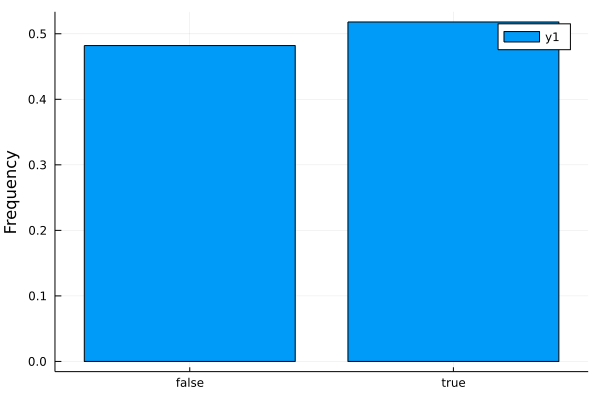

In [3]:
viz(ys)

Here we want to sample 1000 Bernoulli random variables.
We have used the `bar` function to visualize the results of calling the `bernoulli` function 1000 times. As you can see, the result is an approximately uniform distribution over `true` and `false`.

Using `bernoulli`  distribution we can construct more complex expressions that describe more complicated sampling processes. For instance here we describe a process that samples a number adding up several samples (as we can see Julia translated boolean to 0,1)

In [4]:
bernoulli(p)+bernoulli(p)+bernoulli(p)

1

What if we want to invoke this sampling process multiple times? We would like to construct a stochastic function that adds three random numbers each time it is called. We can use `function` to construct such complex stochastic functions from the primitive ones.

In [5]:
function sumFlips() 
    bernoulli(p)+bernoulli(p)+bernoulli(p)
end

sumFlips (generic function with 1 method)

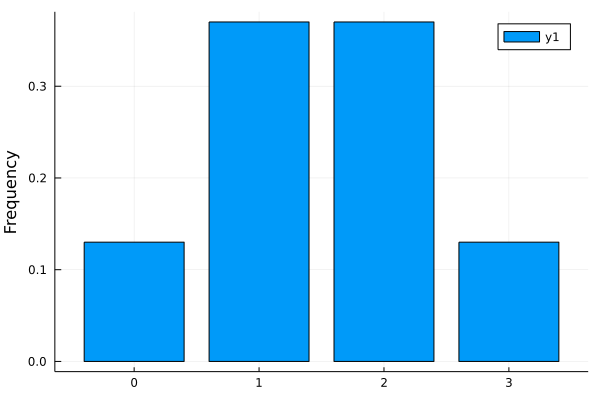

In [6]:
N=100
ys=[sumFlips() for _ in 1:N]
viz(ys)

A function expression with an empty argument list, `function() ... end`, is called a thunk: this is a function that takes no input arguments. If we apply a thunk (to no arguments!) we get a return value back. Complex functions can also have arguments. Here is a stochastic function that will only sometimes double its input:

In [7]:
function noisyDouble(x::Number) 
     bernoulli(p) ? x+x : x 
end
noisyDouble(3)

3

By using higher-order functions we can construct and manipulate complex sampling processes. We use the ternary operator `condition ? if-true : if-false` to induce hierarchy. A good example comes from coin flipping…

### Example: Flipping Coins
The following program defines a fair coin, and flips it 20 times:

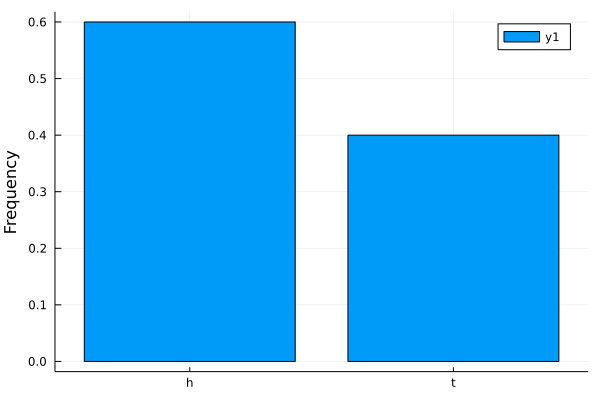

In [8]:
function faircoin()
    bernoulli(p) ? 'h' : 't'
end
N=20
ys=[faircoin() for _ in 1:N ]
viz(ys)

This program defines a “trick” coin that comes up heads most of the time (95%), and flips it 20 times:

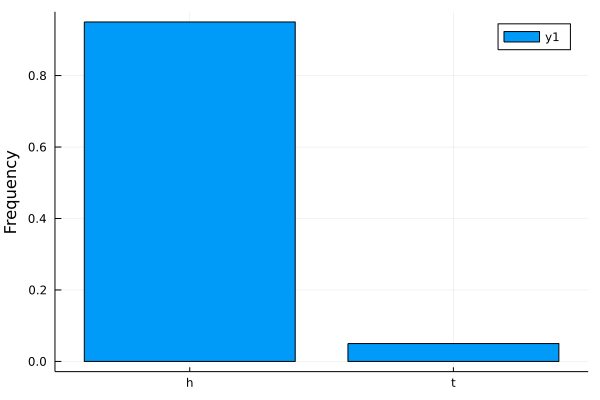

In [9]:
function trickoin()
    bernoulli(0.95) ? 'h' : 't'
end
N=20
ys=[trickoin() for _ in 1:N ]
viz(ys)

The higher-order function `make-coin` takes in a weight and outputs a function (a thunk) describing a coin with that weight. Then we can use `make-coin` to make the coins above, or others.

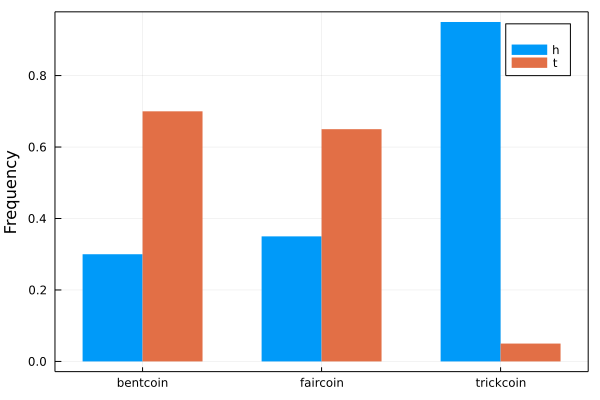

In [10]:
function makecoin(p::Float64)
    function ()
        bernoulli(p) ? 'h' : 't'
    end    
end
faircoin1=makecoin(0.5)
trickcoin1=makecoin(0.95)
bentcoin1=makecoin(0.25)
N=20
counts=zeros(3,2)
y1=[faircoin1()  for _ in 1:N ]
y2=[trickcoin1()  for _ in 1:N ]
y3=[bentcoin1()  for _ in 1:N ]
groupedviz([y1,y2,y3],["faircoin","trickcoin","bentcoin","faircoin","trickcoin","bentcoin"],['h', 't'],3)

We can also define a higher-order function that takes a “coin” and “bends it”:


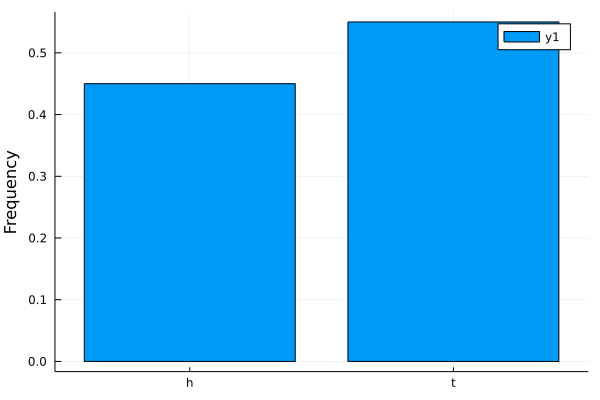

In [11]:
function bend(coin)
    function ()
        coin() == 'h' ? makecoin(0.7)() : makecoin(0.1)()
    end
end
bentcoin2=bend(faircoin1)
N=100
ys=[bentcoin2() for _ in 1:N]
viz(ys)

Make sure you understand how the `bend` function works! Why are there an “extra” pair of parentheses after each `make-coin` statement?

We want to visualize the number of heads we expect to see if we flip a weighted coin (weight = 0.8) 10 times. We’ll repeat this experiment 1000 times and then use `bar` to visualize the results. Try varying the coin weight or the number of repetitions to see how the expected distribution changes.


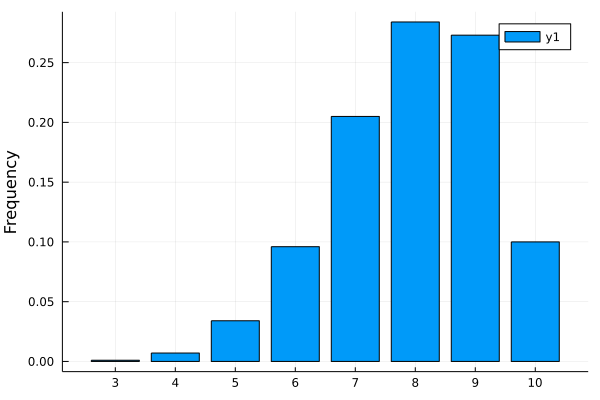

In [12]:
coin=makecoin(0.8)
ys=[sum(map(x -> x == 'h' ? 1 : 0, [coin()  for _ in 1:10])) for _ in 1:1000]
viz(ys)

### Example: Causal Models in Medical Diagnosis
Generative knowledge is often causal knowledge that describes how events or states of the world are related to each other. As an example of how causal knowledge can be encoded in Julia expressions, consider a simplified medical scenario:

In [13]:
lungCancer = bernoulli(0.01)
cold = bernoulli(0.2)
cough = cold || lungCancer

false

This program models the diseases and symptoms of a patient in a doctor’s office. It first specifies the base rates of two diseases the patient could have: lung cancer is rare while a cold is common, and there is an independent chance of having each disease. The program then specifies a process for generating a common symptom of these diseases – an effect with two possible causes: The patient coughs if they have a cold or lung cancer (or both).
Here is a more complex version of this causal model:

In [14]:
lungCancer = bernoulli(0.01)
TB = bernoulli(0.005)
stomachFlu = bernoulli(0.1)
cold = bernoulli(0.2)
other = bernoulli(0.1)

cough = 
    (cold && bernoulli(0.5)) ||
    (lungCancer && bernoulli(0.3)) ||
    (TB && bernoulli(0.7)) ||
    (other && bernoulli(0.01))

fever = 
    (cold && bernoulli(0.3)) ||
    (stomachFlu && bernoulli(0.5)) ||
    (TB && bernoulli(0.1)) ||
    (other && bernoulli(0.01))

chestPain = 
    (lungCancer && bernoulli(0.5)) ||
    (TB && bernoulli(0.5)) ||
    (other && bernoulli(0.01))

shortnessOfBreath = 
    (lungCancer && bernoulli(0.5)) ||
    (TB && bernoulli(0.2)) ||
    (other && bernoulli(0.01))

symptoms = Dict([
  "cough" => cough,
  "fever" => fever,
  "chestPain" => chestPain,
  "shortnessOfBreath" => shortnessOfBreath
])

symptoms

Dict{String, Bool} with 4 entries:
  "cough"             => 0
  "shortnessOfBreath" => 0
  "fever"             => 1
  "chestPain"         => 0

Now there are four possible diseases and four symptoms. Each disease causes a different pattern of symptoms. The causal relations are now probabilistic: Only some patients with a cold have a cough (50%), or a fever (30%). There is also a catch-all disease category “other”, which has a low probability of causing any symptom. Noisy logical functions—functions built from and `(&&)`, or `(||)`, and `bernoulli`—provide a simple but expressive way to describe probabilistic causal dependencies between Boolean (true-false valued) variables.
When you run the above code, the program generates a list of symptoms for a hypothetical patient. Most likely all the symptoms will be false, as (thankfully) each of these diseases is rare. Experiment with running the program multiple times. Now try modifying the statement for one of the diseases, setting it to be true, to simulate only patients known to have that disease. For example, replace `lungCancer = bernouli(0.01)` with  `lungCancer = true`. Run the program several times to observe the characteristic patterns of symptoms for that disease.

### Prediction, Simulation, and Probabilities
Suppose that we flip two fair coins, and return the list of their values:

In [15]:
[bernoulli(0.5),bernoulli(0.5)]

2-element Vector{Bool}:
 0
 0

How can we predict the return value of this program? For instance, how likely is it that we will see `[1, 0]`? A probability is a number between 0 and 1 that expresses the answer to such a question: it is a degree of belief that we will see a given outcome, such as `[1, 0]`. The probability of an event A (such as the above program returning `[1, 0]`) is usually written as: `P(A)`.
A probability distribution is the probability of each possible outcome of an event. For instance, we can examine the probability distribution on values that can be returned by the above program by sampling many times and examining the histogram of return values:

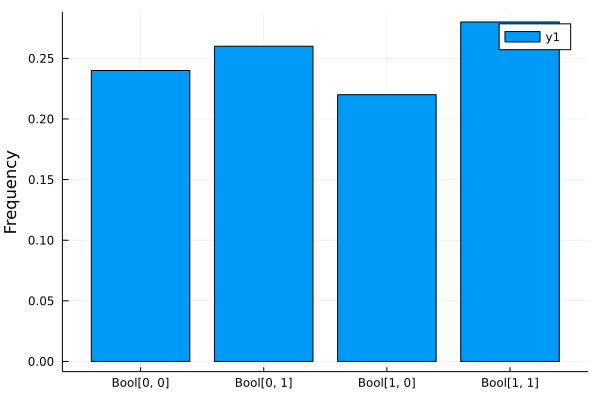

In [16]:
function radomPair()    
    [bernoulli(0.5),bernoulli(0.5)]
    
end
N=100
ys=[radomPair()  for _ in 1:N ]
viz(ys)

We see by examining this histogram that `[1, 0]` comes out about 25% of the time. We may define the probability of a return value to be the fraction of times (in the long run) that this value is returned from evaluating the program – then the probability of `[1, 0]` from the above program is 0.25.

### Distributions in Gen
An important idea is that `bernoulli` can be thought of in two different ways. From one perspective,`bernoulli` is a procedure which returns a sample from a fair coin. That is, it’s a sampler or simulator. As we saw above we can build more complex samplers by building more complex functions. From another perspective, `bernoulli` is itself a characterization of the probability distribution over `true` and `false`. In order to make this view explicit, Gen has a special type of distribution objects. These are objects that can be sampled from using the `simulate` operator, and that can explicitly return the probability of a return value using the `get_score` method. Distributions are made by a family of distribution constructors:


true
-0.6931471805599453


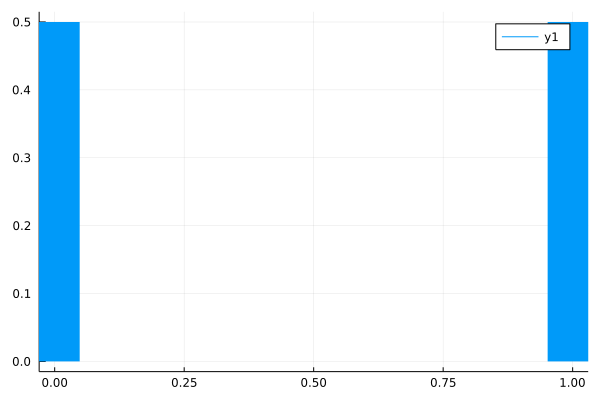

In [17]:
using Distributions, Gen
@gen function foo()
    @trace(bernoulli(0.5), :b)
end
#sample from it with the simulate operator:
trace = simulate(foo, ())
println(trace[:b])
#compute the log-probability of sampled data:
println(Gen.get_score(trace))
#visualize the distribution using julia native Bernoulli sampler:
plot(Bernoulli(0.5), lw=50)

There are many other distribution constructors built into Gen listed [here](https://www.gen.dev/stable/ref/distributions/). For instance the  Normal distribution is a very common distribution over real numbers:

In [18]:
@gen function goo()
    @trace(normal(0, 1) , :g)
end
#sample from it with the simulate operator:
trace = simulate(goo, ())
println(trace[:g])

#can also use the sampling helper (note lower-case name):
println(normal(0,1))

#and build more complex processes!
hoo = () -> normal(0,1) * normal(0,1) 
hoo()


0.0678195371421756
1.8279203503177355


1.5772975439485837

### Constructing complex distributions:
Above we described how complex sampling processes can be built as complex functions, and how these sampling processes implicitly specify a distribution on return values (which we examined by sampling many times and building a histogram). Forward sampeling gives us a way to make this implicit distribution into an explicit distribution object:

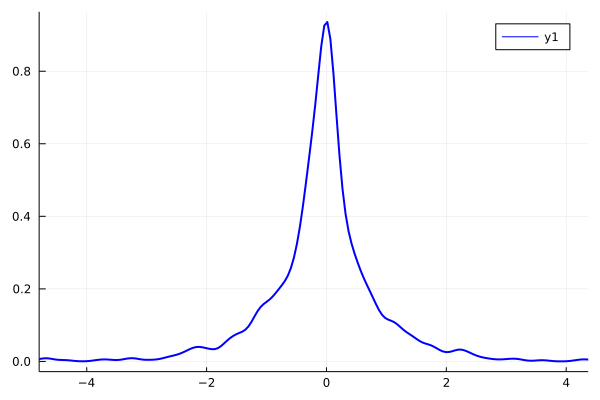

In [19]:
@gen function complexDist()
    a=@trace(normal(0, 1), :a)
    b=@trace(normal(0, 1), :b)
    a*b
end
traces=[simulate(complexDist,()) for _ in 1:1000]
ret_values=map(x -> Gen.get_retval(x),traces)

p = plot(ret_values, seriestype = :density, xlim = (minimum(ret_values),maximum(ret_values)), legend = :best, w = 2, c = :blue)


?????? Note that Infer took an object describing how to construct the marginal distribution (which we will describe more later) and a thunk describing the sampling process, or model, of interest. For more details see the Infer documentation.

Thus sample lets us sample from a distribution, and build complex sampling processes by using sampling in a program; conversely, Infer lets us reify the distribution implicitly described by a sampling process.

When we think about probabilistic programs we will often move back and forth between these two views, emphasizing either the sampling perspective or the distributional perspective. With suitable restrictions this duality is complete: any WebPPL program implicitly represents a distribution and any distribution can be represented by a WebPPL program; see e.g., Ackerman et al. (2011) for more details on this duality.??????

## The rules of probability ?????
While Infer lets us build the marginal distribution for even very complicated programs, we can also derive these marginal distributions with the “rules of probability”. This is intractable for complex processes, but can help us build intuition for how distributions work.
### Product Rule
In the above example we take three steps to compute the output value: we sample from the first `bernoulli()`, then from the second, then we make a list from these values. To make this more clear let us re-write the program as:

In [20]:
a=bernoulli(0.5)
b=bernoulli(0.5)
c=[a,b]

2-element Vector{Bool}:
 1
 1

We can directly observe (as we did above) that the probability of `true` for `A` is 0.5, and the probability of `false` from `B` is 0.5. Can we use these two probabilities to arrive at the probability of 0.25 for the overall outcome `C` = `[true, false]`? Yes, using the product rule of probabilities: The probability of two random choices is the product of their individual probabilities. The probability of several random choices together is often called the joint probability and written as *P(A,B)*. Since the first and second random choices must each have their specified values in order to get `[true, false]` in the example, the joint probability is their product: 0.25.
We must be careful when applying this rule, since the probability of a choice can depend on the probabilities of previous choices. For instance, we can visualize the the exact probability of `[true, false]` resulting from this program:

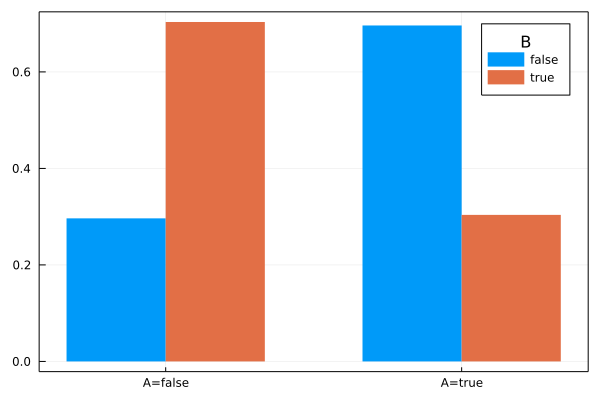

In [21]:
@gen function c()
    a=@trace(bernoulli(0.5), :a)
    b=@trace(bernoulli(a ? 0.3 : 0.7), :b)
    (a,b)
end
values=[simulate(c,()) for _ in 1:1000]
a0=map(x -> get_retval(x)[:2],filter(x -> get_retval(x)[:1]==0, values))
a1=map(x -> get_retval(x)[:2],filter(x -> get_retval(x)[:1]==1, values))
groupedviz([a0,a1],["A=false","A=true","A=false","A=true"],[false,true],2,"","","","B")


In general, the joint probability of two random choices `A` and `B` made sequentially, in that order, can be written as *P(A,B)=P(A)P(B|A)*. This is read as the product of the probability of `A` and the probability of *"B given A"*, or *"B conditioned on A"*. That is, the probability of making choice `B` given that choice `A` has been made in a certain way. Only when the second choice does not depend on (or "look at") the first choice does this expression reduce to a simple product of the probabilities of each choice individually: $P(A,B)=P(A)P(B)$.
What is the relation between $P(A,B)$ and $P(B,A)$, the joint probability of the same choices written in the opposite order? The only logically consistent definitions of probability require that these two probabilities be equal, so $P(A)P(B|A)=P(B)P(A|B)$. This is the basis of Bayes' theorem, which we will encounter later.

### Sum Rule
Now let's consider an example where we can't determine from the overall return value the sequence of random choices that were made:

In [22]:
bernoulli(0.5) || bernoulli(0.5)


true

We can sample from this program and determine that the probability of returning `true` is about 0.75.
We cannot simply use the product rule to determine this probability because we don't know the sequence of random choices that led to this return value. However we can notice that the program will return true if the two component choices are `[true, true]`, or `[true, false]`, or `[false, true]`. To combine these possibilities we use another rule for probabilities: If there are two alternative sequences of choices that lead to the same return value, the probability of this return value is the sum of the probabilities of the sequences. We can write this using probability notation as: *$P(A)$ = $\sum_{\substack{B}} P(A, B)$*, where we view A as the final value and B as a random choice on the way to that value. Using the product rule we can determine that the probability in the example above is 0.25 for each sequence that leads to return value `true`, then, by the sum rule, the probability of `true` is 0.25+0.25+0.25=0.75.
Using the sum rule to compute the probability of a final value is called is sometimes called *marginalization*, because the final distribution is the marginal distribution on final values. From the point of view of sampling processes marginalization is simply ignoring (or not looking at) intermediate random values that are created on the way to a final return value. From the point of view of directly computing probabilities, marginalization is summing over all the possible "histories" that could lead to a return value. Putting the product and sum rules together, the marginal probability of return values from a program that we have explored above is the sum over sampling histories of the product over choice probabilities—a computation that can quickly grow unmanageable, but can be approximated by sampling.

## Stochastic recursion
Recursive functions are a powerful way to structure computation in deterministic systems. In Gen it is possible to have a *stochastic* recursion that randomly decides whether to stop. For example, the *geometric distribution* is a probability distribution over the non-negative integers. We imagine flipping a (weighted) coin, returning N−1 if the first `true` is on the Nth flip (that is, we return the number of times we get `false` before our first `true`):

In [35]:
@gen function production(p)
    bernoulli(p) ? 0 : production(p)
end
@gen function reduction(x)
    1+x
end
geo=Gen.Recurse(production, reduction)
data=[geo(0.6) for _ in 1:1000]
viz(data)

LoadError: MethodError: no method matching Recurse(::DynamicDSLFunction{Any}, ::DynamicDSLFunction{Any})
[0mClosest candidates are:
[0m  Recurse(::GenerativeFunction{X, S}, ::GenerativeFunction{Y, T}, [91m::Int64[39m, [91m::Type{U}[39m, [91m::Type{V}[39m, [91m::Type{W}[39m) where {S, T, U, V, W, X, Y} at C:\Users\kudis\.julia\packages\Gen\LBj96\src\modeling_library\recurse\recurse.jl:125

There is no upper bound on how long the computation can go on, although the probability of reaching some number declines quickly as we go. Indeed, stochastic recursions must be constructed to halt eventually (with probability 1).

### Persistent Randomness: `Memoize`
It is often useful to model a set of objects that each have a randomly chosen property. For instance, describing the eye colors of a set of people:

In [ ]:
@gen function eyeColor(person)
    colors= ["blue", "green", "brown"]
    i =@trace(uniform_discrete(1, 3), :i)
    colors[i]    
end
[eyeColor("bob"), eyeColor("alice"), eyeColor("bob")]

3-element Vector{String}:
 "brown"
 "brown"
 "blue"

The results of this generative process are clearly wrong: Bob's eye color can change each time we ask about it! What we want is a model in which eye color is random, but persistent. We can do this using a Julia package: `Memoize`. `@memoize` is a macro that can be applied to a procedure and produces a memoized version of the procedure. When a stochastic procedure is memoized, it will sample a random value the first time it is used with some arguments, but return that same value when called with those arguments thereafter. The resulting memoized procedure has a persistent value within each "run" of the generative model (or simulated world). For instance consider the equality of two flips, and the equality of two memoized flips:

In [ ]:
bernoulli(0.5) == bernoulli(0.5)

true

In [ ]:
using Memoize
@memoize function ber()
    bernoulli(0.5)
end

ber()==ber()

true

Now returning to the eye color example, we can represent the notion that eye color is random, but each person has a fixed eye color.

In [ ]:
@memoize function eyeColor2(person)
    eyeColor(person)    
end
[eyeColor2("bob"), eyeColor2("alice"), eyeColor2("bob")]

3-element Vector{String}:
 "blue"
 "green"
 "blue"

This type of modeling is called *random world* style (McAllester et al., 2008). Note that we don't have to specify ahead of time the people whose eye color we will ask about: the distribution on eye colors is implicitly defined over the infinite set of possible people, but only constructed "lazily" when needed. Memoizing stochastic functions thus provides a powerful toolkit to represent and reason about an unbounded set of properties of an unbounded set of objects. For instance, here we define a function `flipAlot` that maps from an integer (or any other value) to a coin flip. We could use it to implicitly represent the *n*th flip of a particular coin, without having to actually flip the coin *n* times.

In [ ]:
@memoize function flipAlot(n)
    bernoulli(0.5)
end
[flipAlot(1) flipAlot(12) flipAlot(47) flipAlot(1548);flipAlot(1) flipAlot(12) flipAlot(47) flipAlot(1548)]

2×4 Matrix{Bool}:
 0  0  1  1
 0  0  1  1

There are a countably infinite number of such flips, each independent of all the others. The outcome of each, once determined, will always have the same value.

In computer science memoization is an important technique for optimizing programs by avoiding repeated work. In the probabilistic setting, such as in Julia and Gen, memoization actually affects the meaning of the memoized function.